# Mentoría 'de cómo clasificar en géneros a las canciones'
## Práctico II : Análisis de features de audio

Algunas aclaraciones:
- En 2) todos los pasos deberían poder hacerse en una línea, aunque si se complican y necesitan hacerlo en más no hay problema
- En 3) les dejé un buen spoiler para que lo completen
- Todas los conceptos y librerias que vamos a usar están documentados en el notebook
- Esta vez vamos a ser más rígidos con los plazos, la entrega es el 05/08, la única instancia previa de corrección son las entregas ANTES de la fecha mencionada, caso contrario es la nota final.

### Librerías

!pip3 install spotipy
!pip3 install pandas
!pip3 install spacy
!pip3 install pymusixmatch
!pip3 install nltk
!pip3 install wordcloud
!pip3 install matplotlib
!pip3 install seaborn

# Agregar las librerías extra que se utilicen en esta celda y la siguiente

### Dependencias y acceso al API

In [1]:
import pandas as pd
import numpy as np
import spotipy
import spacy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import json
import seaborn as sns
import tqdm
from collections import Counter
from nltk import ngrams, bigrams
import nltk
import itertools
from wordcloud import WordCloud
import matplotlib.pyplot as plt



client_id = '46b333d567314a89a6254b6c6b054be6'
client_secret = '9d922c3613e441518349dcf55f7d5853'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

nlp = spacy.load("en_core_web_sm") #completar con el modelo que van a utilizar

sns.set_context(context='paper')

In [2]:
# aux methods

def song_url_for_request(artist, song_title):
    return "https://api.lyrics.ovh/v1/" + artist + '/' + song_title #str
    #example use
    #requests.get(song_url_for_request("Death Grips", "Hacker"))
    

def songs_from_album_id(album_id):
    songs = []
    album = sp.album(album_id)
    artist = album['artists'][0]['name']
    for item in album['tracks']['items']:
        track = {}
        track["song_name"] = item['name']
        track["lyrics"]=[]
        track["song_id"] = item['id']
        track["album_name"] = album['name']
        track["album_id"] = album["id"]
        track["artist"] = artist
        songs.append(track)
    return songs    #songs:List[dict]



def genres_by_artist_id(id): #id: str
    artist = sp.artist(id)
    genres = artist['genres']
    return genres    #genres: List[str]

In [3]:
genres_by_artist_id("5K4W6rqBFWDnAN6FQUkS6x")

['chicago rap', 'rap']

## Question:
- How has Kanye West's vocabulary evolved through time?

### From this question we can derive:
- Are there many differences from album to album?
- Can we differentiate epochs in Kanye West's career by analysing his songs' vocabulary?

### 2) Obtener datos para responder la pregunta
Una vez obtenidas las letras de las canciones, las procesaremos de la siguiente manera:
1. Tokenizar
2. Remover las [stop-words](https://es.wikipedia.org/wiki/Palabra_vac%C3%ADa)
3. [Lema](https://es.wikipedia.org/wiki/Lema_(ling%C3%BC%C3%ADstica))tizar las palabras que hayan quedado
4. Organizar todo en un DataFrame de la forma Canción-Artista-Letra donde Letra es el resultado de 3.

**Recomendación** : Usar un dataframe para su artista y otro para la competencia si es que eligierone esa opción, les va a ahorrar tiempo.

**Aclaración** : Si plantearon una pregunta que no requiera los datos de la consigna, obtengan esos datos.

First we build Kanye West's dataset. We'll be using lyrics from 11 albums;

- Jesus is King
- Kids see ghosts
- ye
- The life of pablo
- Yeezus
- Watch the throne
- My beautiful dark twisted fantasy
- Graduation
- 808s & Heartbreak
- Late Registration
- The college dropout

for a total of 151 songs. After sanitization, 133.

In [4]:
kanye_west=["0FgZKfoU2Br5sHOfvZKTI9",
           "6pwuKxMUkNg673KETsXPUV",
           "2Ek1q2haOnxVqhvVKqMvJe",
           "7gsWAHLeT0w7es6FofOXk1",
           "7D2NdGvBHIavgLhmcwhluK",
           "2P2Xwvh2xWXIZ1OWY9S9o5",
           "20r762YmB5HeofjMCiPMLv",
           "5fPglEDz9YEwRgbLRvhCZy",
           "3WFTGIO6E3Xh4paEOBY9OU",
           "5ll74bqtkcXlKE7wwkMq4g",
           "4Uv86qWpGTxf7fU7lG5X6F"]

In [5]:
ALBUM_IDS = kanye_west


def lemmafy(doc):
    lemmas = []
    for token in doc:
        if not token.is_stop and token.is_alpha:
             lemmas.append(token.lemma_)
    return lemmas

In [6]:
#arm base dataset
def build_from_album_ids(album_id_array):
    all_songs = []
    for album in tqdm.tqdm(album_id_array):
        all_songs += songs_from_album_id(album)
    return all_songs
    
all_songs = build_from_album_ids(ALBUM_IDS)

100%|██████████| 11/11 [00:03<00:00,  3.35it/s]


In [7]:
#put song lyrics in dataset
def add_lyrics_to_data(all_songs):
    for song in tqdm.tqdm(all_songs):
        response = requests.get(song_url_for_request(song["artist"],song["song_name"]))
        json_data = json.loads(response.content)
        try:
            lyrics_raw = json_data["lyrics"]
            doc = nlp(lyrics_raw)
            lemmed = lemmafy(doc)
            song["lyrics"]=[word.lower() for word in lemmed]
        except: #found a song without lyrics!
            print(song["song_name"])
            song["lyrics"]=None
    return all_songs

all_songs = add_lyrics_to_data(all_songs)


  1%|          | 1/151 [00:02<05:39,  2.26s/it]

Every Hour


  4%|▍         | 6/151 [00:09<03:43,  1.54s/it]

Everything We Need


  7%|▋         | 10/151 [00:14<03:27,  1.47s/it]

Use This Gospel


 10%|▉         | 15/151 [00:21<03:09,  1.39s/it]

Freeee (Ghost Town Pt. 2)


 37%|███▋      | 56/151 [01:19<02:10,  1.37s/it]

No Church In The Wild


 38%|███▊      | 58/151 [01:21<02:10,  1.41s/it]

Ni**as In Paris


 40%|███▉      | 60/151 [01:24<02:06,  1.39s/it]

Gotta Have It


 41%|████      | 62/151 [01:27<02:04,  1.40s/it]

That's My Bitch


 42%|████▏     | 63/151 [01:28<02:03,  1.40s/it]

Welcome To The Jungle


 42%|████▏     | 64/151 [01:30<02:05,  1.44s/it]

Who Gon Stop Me


 43%|████▎     | 65/151 [01:31<02:03,  1.44s/it]

Murder To Excellence


 44%|████▎     | 66/151 [01:33<02:02,  1.44s/it]

Made In America


 44%|████▍     | 67/151 [01:34<02:03,  1.47s/it]

Why I Love You


 45%|████▌     | 68/151 [01:36<02:03,  1.49s/it]

Illest Motherf**ker Alive


 46%|████▌     | 69/151 [01:37<02:00,  1.47s/it]

H•A•M


 46%|████▋     | 70/151 [01:39<01:58,  1.46s/it]

Primetime


 47%|████▋     | 71/151 [01:40<01:58,  1.48s/it]

The Joy


 85%|████████▌ | 129/151 [03:02<00:31,  1.45s/it]

Diamonds From Sierra Leone - Bonus Track


100%|██████████| 151/151 [03:34<00:00,  1.42s/it]


In [9]:
songs_base = pd.DataFrame(all_songs)
len(all_songs)


151

In [10]:
# sanitize
bool_series = pd.notnull(songs_base["lyrics"])
songs_base = songs_base[bool_series]
songs_base.head(2)

,album_id,album_name,artist,lyrics,song_id,song_name
1,0FgZKfoU2Br5sHOfvZKTI9,JESUS IS KING,Kanye West,"[god, king, soldier, ultrabeam, solar, heaven,...",39JRmdKFka1Oe09FoOCPI4,Selah
2,0FgZKfoU2Br5sHOfvZKTI9,JESUS IS KING,Kanye West,"[father, stretch, stretch, hand, lifelike, lif...",2QpGZOhTCHHiKmpSO9FW4h,Follow God


In [11]:
# build separate dfs for each album
albums = songs_base["album_name"].unique()
albums_dfs = {}
for album in tqdm.tqdm(albums):
    album_df = pd.DataFrame(songs_base[songs_base["album_name"]==album])
    albums_dfs[album] = album_df
albums_dfs.keys()

100%|██████████| 11/11 [00:00<00:00, 1208.20it/s]


dict_keys(['JESUS IS KING', 'KIDS SEE GHOSTS', 'ye', 'The Life Of Pablo', 'Yeezus', 'Watch The Throne (Deluxe)', 'My Beautiful Dark Twisted Fantasy', 'Graduation', '808s & Heartbreak', 'Late Registration', 'The College Dropout'])

### 3) Encontrar los n-gramas (n= 1, 2) más comunes y usarlos en gráficos.
Utilizando las librerías de la celda de abajo obtendremos los conjuntos de 1 y 2 palabras más comunes para cada artista con el que trabajaremos. Luego usaremos los unigramas para graficar una [word-cloud](https://i.imgur.com/8I8aJ1N.png) y un gráfico de distribución de frecuencia para unigramas y bigramas por autor (o de la forma que se adapte a su pregunta).

In [13]:
songs_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 1 to 150
Data columns (total 6 columns):
album_id      133 non-null object
album_name    133 non-null object
artist        133 non-null object
lyrics        133 non-null object
song_id       133 non-null object
song_name     133 non-null object
dtypes: object(6)
memory usage: 7.3+ KB


In [14]:
albums_dfs['JESUS IS KING']["lyrics"]#.keys()

1     [god, king, soldier, ultrabeam, solar, heaven,...
2     [father, stretch, stretch, hand, lifelike, lif...
3     [close, sunday, chick, fil, close, sunday, chi...
4     [yo, yo, favor, accept, lord, saviour, reply, ...
6     [water, water, water, water, purest, water, li...
7     [god, light, darkness, oh, god, god, turn, god...
8     [hand, hand, high, hand, hand, hand, hand, fac...
10    [knee, shall, bow, tongue, confess, jesus, lor...
Name: lyrics, dtype: object

In [15]:
lyrics = list(itertools.chain(songs_base["lyrics"].values))
full_lyrics = [j for i in lyrics for j in i]
len(full_lyrics)

27208

In [16]:
def divide_lyrics_by_album(albums):
    lyrics_by_album = {}
    for album in albums:
        lyrics =  list(itertools.chain(albums_dfs[album]["lyrics"].values))
        lyrics = [j for i in lyrics for j in i]
        lyrics_by_album[album] = lyrics
    return lyrics_by_album
    
lyrics_by_album = divide_lyrics_by_album(albums)

In [17]:
# aux functions
def uniques(ngram_counts,n):
    uniques = []
    for ele in ngram_counts:
        if ngram_counts[ele]==1:
            if n == 1:
                uniques.append(ele[0])
            if n == 2:
                uniques.append(ele)
    return uniques

def ngrams_of_album(albums):
    uni_tokens = ngrams(lyrics_by_album[album],1)
    bi_tokens = bigrams(lyrics_by_album[album])
    bi_counts = Counter(bi_tokens)
    uni_counts = Counter(uni_tokens)
    uni_uniques = uniques(uni_counts, 1)
    bi_uniques = uniques(bi_counts, 2)
    #print("\n")
    #print("Unigrams of " + album +" :", uni_counts.most_common(3))
    #print("\n")
    #print("Bigrams of "+album+" :", bi_counts.most_common(3))
    return uni_counts, bi_counts, uni_uniques, bi_uniques

def plot_wordcloud_from_string(text, title):
    stopwords=["nada"]
    wordcloud = WordCloud(width=880, height=480, 
                          max_font_size = 1120,margin=0,
                          background_color="black",relative_scaling=.5,
                          collocations=False,
                         stopwords=stopwords).generate(text) 
                            #collocations= False so it doesn't show bigrams
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear',)
    plt.axis("off")
    plt.title('WORD CLOUD of '+title, fontsize = 20)
    plt.margins(x=0, y=0)
    plt.show()
    return wordcloud

Now that we have the lyrics across all albums in a list, we can count the unigrams and the bigrams.

In [18]:
uni_tokens = ngrams(full_lyrics,1)
bi_tokens = bigrams(full_lyrics)
bi_counts = Counter(bi_tokens)
uni_counts = Counter(uni_tokens)
#print([(item, counts.count(item)) for item in sorted(set(bi_tokens))])
uni_uniques = uniques(uni_counts, 1)
print("Unigrams:", uni_counts.most_common(5))
print("\n")
print("Bigrams:", bi_counts.most_common(5))
print("\n")
print("Amount of uniques: ", len(uni_uniques))

Unigrams: [(('know',), 476), (('like',), 469), (('get',), 344), (('be',), 287), (('love',), 248)]


Bigrams: [(('la', 'la'), 79), (('kanye', 'west'), 70), (('movin', 'forward'), 67), (('go', 'to'), 65), (('water', 'water'), 59)]


Amount of uniques:  2439


We can also divide this analysis by album

In [19]:
# get different data of each album
ye_uni_counts, ye_bi_counts, ye_uni_uniques, ye_bi_uniques = ngrams_of_album("ye")
yeezus_uni_counts, yeezus_bi_counts, yeezus_uni_uniques, yeezus_bi_uniques = ngrams_of_album("Yeezus")
grad_uni_counts, grad_bi_counts, grad_uni_uniques, grad_bi_uniques = ngrams_of_album("Graduation")
pablo_uni_counts, pablo_bi_counts, pablo_uni_uniques, pablo_bi_uniques = ngrams_of_album("The Life Of Pablo")
heart_uni_counts, heart_bi_counts, heart_uni_uniques, heart_bi_uniques = ngrams_of_album("808s & Heartbreak")
jik_uni_counts, jik_bi_counts, jik_uni_uniques, jik_bi_uniques = ngrams_of_album("JESUS IS KING")
kids_uni_counts, kids_bi_counts, kids_uni_uniques, kids_bi_uniques = ngrams_of_album("KIDS SEE GHOSTS")
throne_uni_counts, throne_bi_counts, throne_uni_uniques, throne_bi_uniques = ngrams_of_album("Watch The Throne (Deluxe)")
fan_uni_counts, fan_bi_counts, fan_uni_uniques, fan_bi_uniques = ngrams_of_album("My Beautiful Dark Twisted Fantasy")
reg_uni_counts, reg_bi_counts, reg_uni_uniques, reg_bi_uniques = ngrams_of_album("Late Registration")
drop_uni_counts, drop_bi_counts, drop_uni_uniques, drop_bi_uniques = ngrams_of_album("The College Dropout")

### 4) Escribir un informe

Este informe tiene que describir qué datos que obtuvieron, el volumen de estos (# de canciones del artista, # de canciones de la competencia, etc), una explicación de cómo estos se relacionan con la pregunta planteada, cómo ayudan a responderla y los resultados que obtuvieron. Usar la celda de abajo con formato markdown.




# Report

## Dataset

## Question:

In this report I'm going to explore the dataset built around Kanye West's songs in order to answer the following question

> How has Kanye West's vocabulary evolved through time?

From this question we can derive:

> Are there major differences from album to album?

> Can we differentiate epochs in Kanye West's career by analysing his songs' vocabulary?

## General Analysis

First let's make a through analysis of the vocabulary of Kanye West's career as a whole.

We can see a word cloud of all the dataset's lyrics.

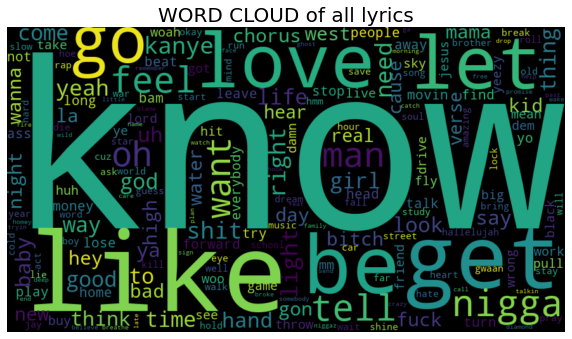

In [20]:
text_from_full_lyrics = " ".join(full_lyrics)
all_lyrics_plot = plot_wordcloud_from_string(text_from_full_lyrics, "all lyrics")

We can see the predominance of the word *know*, which will be seen as most common in most of Kanye's albums. The same case happens in a less pronounced way with *love* and *light*.

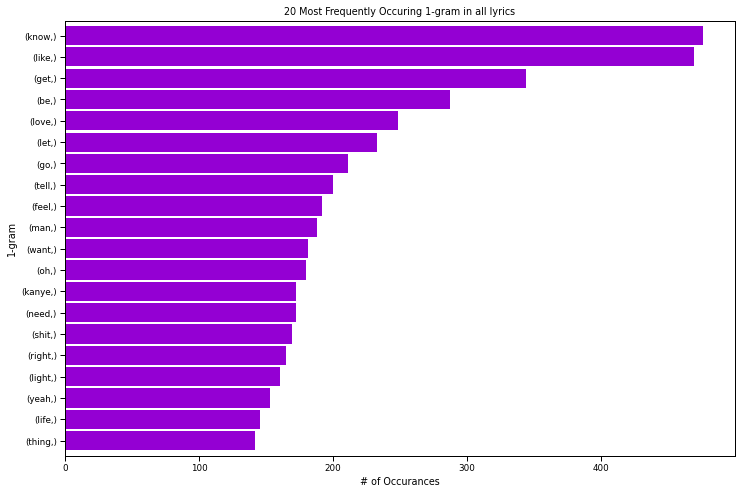

In [21]:
def plot_freq(lyrics,*,n_of_ngram, amount, more_info):
    ngrams_series =pd.Series(nltk.ngrams(full_lyrics,n_of_ngram)).value_counts()[:20]
    ngrams_series.sort_values().plot.barh(color='darkviolet', width=.9, figsize=(12, 8))
    plt.title(str(amount)+' Most Frequently Occuring '+str(n_of_ngram)+'-gram'+' in '+more_info)
    plt.ylabel(str(n_of_ngram)+'-gram')
    plt.xlabel('# of Occurances')

plot_freq(full_lyrics, n_of_ngram=1,amount=20,more_info="all lyrics")

We can get a more quantifiable overview of the unigrams in this unigram frequencies plot.

*know* and *like* surpass the rest of the unigrams by a large margin.

Following up we have a few common verbs in the english language *get*, *let*, *go*, *be*.

More interesting repeating nouns are *love*, *feel*, *shit*, *life*, *man*. 

Kanye West's career's vocabulary, in general, involves everyday words, that talk about what most people consider important in their lives -love, feelings, possessions-. There's an interest in reflecting on what a human possesses, what they can acquire, and what that means.

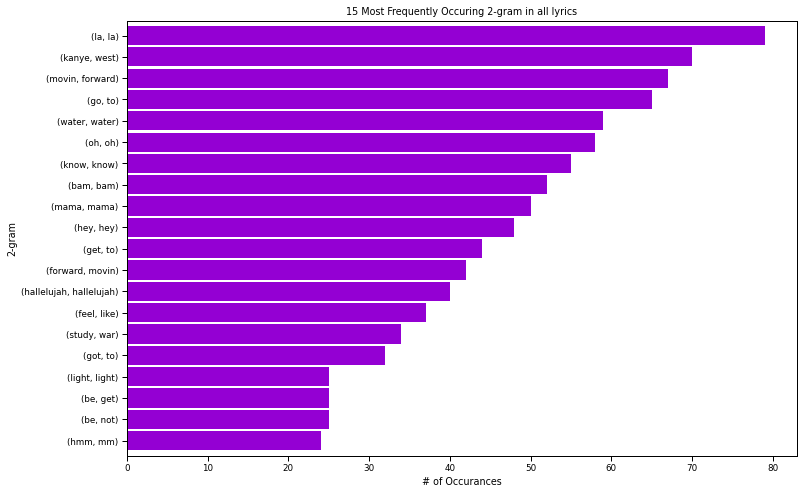

In [22]:
plot_freq(full_lyrics, n_of_ngram=2,amount=15,more_info="all lyrics")

We can see that *Kanye West* is the most recurring bigram. This has more to do with the way rap's lyrics are written down than with Kanye's vocabulary. More on this on **Problems found** section.

Other than that particular case, *la la* is the most frequent bigram, and it corresponds with other rythmic onomatopoeia, like *bam bam*, *oh oh*, *mm woah* , *hey hey*. 

In most cases, frequent bigrams are the result of repeating words.

More interesting for a qualitative analysis are the cases where different words that happen to be together frequently. That's the case with:

* Moving forward, 
* study war, 
* get to, 
* feel like,
* go to, 
* look like,
* be get, 
* tell ya

From that we can form a more meaninful overview of the concepts that are most frequently expressed in Kanye's lyrics. There is an interest in expressing feelings, expressing both internal and external movement, to talk about appearence and to talk about what has been talked about, as in to tell stories through the memories of dialogues. 

From the 27385 words that compose the lyrics dataset, 2411 are unique words. That is a proportion of 8.8% of the words said in total. There is a stronger interest in talking through simple, everyday words which is also shown in the average length of a word in the overall lyrics, being ~5 character per word  - unique words seem to have almost the same behavior, with an average of 6 chars in each word.

In [23]:
lengths_all =[len(word) for word in full_lyrics]
lengths_uniques = [len(word) for word in uni_uniques]
avg_uniques=sum(lengths_uniques)/len(lengths_uniques)
avg_all=sum(lengths_all)/len(lengths_all)
print("Average length of a word: ", round(avg_all,3))
print("Average length of an unique word: ", round(avg_uniques,3))

Average length of a word:  4.606
Average length of an unique word:  6.341


In [43]:
lengths_count = Counter(lengths_all)
lengths_count = dict(lengths_count)
unique_lengths_count = Counter(lengths_uniques)
unique_lengths_count = dict(unique_lengths_count)


Text(0.5, 0, '# of Occurances')

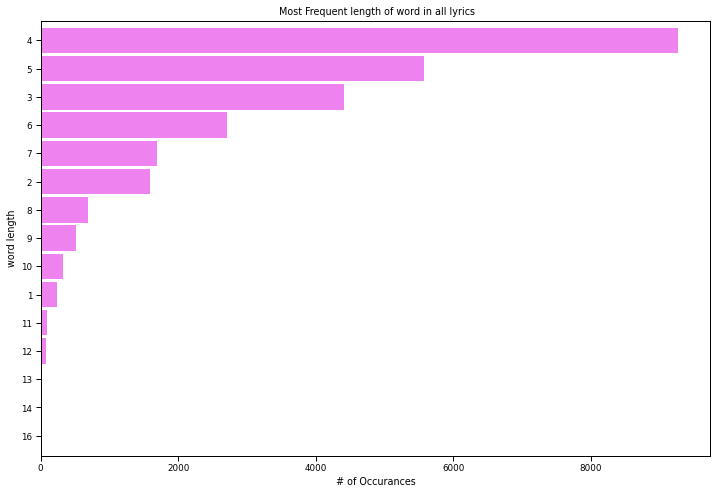

In [49]:
word_length_series =pd.Series(lengths_count)
word_length_series.sort_values().plot.barh(color='violet', width=.9, figsize=(12, 8))
plt.title(' Most Frequent length of word in all lyrics')
plt.ylabel('word length')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

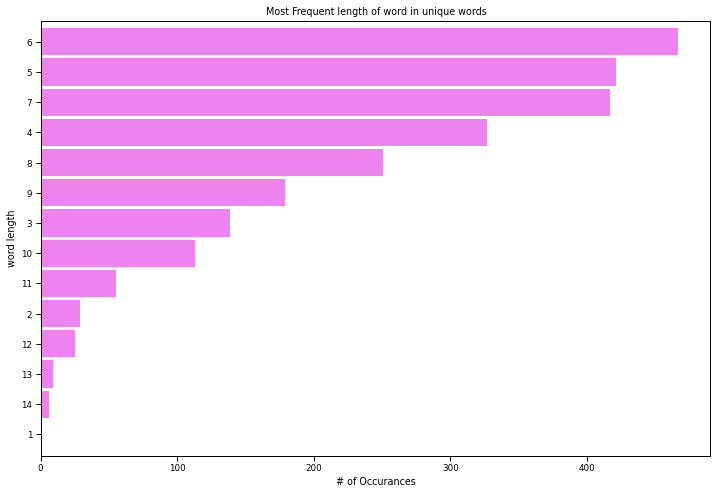

In [46]:
word_length_series =pd.Series(unique_lengths_count)
word_length_series.sort_values().plot.barh(color='violet', width=.9, figsize=(12, 8))
plt.title(' Most Frequent length of word in unique words')
plt.ylabel('word length')
plt.xlabel('# of Occurances')

## Analysis through the albums

In order to analyse the vocabulary through the albums let's see the wordclouds in order of the albums release.

In [ ]:
albums_in_order = ['The College Dropout',
                   'Late Registration',
                   'Graduation',
                   '808s & Heartbreak',
                   'My Beautiful Dark Twisted Fantasy',
                   'Watch The Throne (Deluxe)',
                   'Yeezus',
                   'The Life Of Pablo',
                   'ye',
                   'KIDS SEE GHOSTS',
                   'JESUS IS KING',
                  ]

In [ ]:
for album in albums_in_order[:3]:
    plot_wordcloud_from_string(" ".join(lyrics_by_album[album]), album)

In [ ]:
for album in albums_in_order[3:6]:
    plot_wordcloud_from_string(" ".join(lyrics_by_album[album]), album)

In [ ]:
for album in albums_in_order[6:9]:
    plot_wordcloud_from_string(" ".join(lyrics_by_album[album]), album)

In [ ]:
for album in albums_in_order[9:]:
    plot_wordcloud_from_string(" ".join(lyrics_by_album[album]), album)

## Problemas Encontrados

Las letras traen (kanye west) y nombres de raperos adentro delas letras por cómo se estucturan las letras de rap en genral

problema de dialectos y aave que dificulta contabilizar ocurrencias/distribuciones